<a href="https://colab.research.google.com/github/project-ida/two-state-quantum-systems/blob/master/03-a-two-state-system-in-a-quantised-field.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <a href="https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/03-a-two-state-system-in-a-quantised-field.ipynb" target="_parent"><img src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

# 3 - A two state system in a quantised field

This tutorial is all about going to the next level in thinking about how two state systems interact with their environment. In the last tutorial, we actually took a semi-classical view of the effect of a perturbation - now we must be go full quantum if we are to continue on our quantum quest!

We are covering a lot here so we've chunked it up into sections:

1. Recap
2. What is a quantum field?
3. The Hamiltonian for a quantum field
4. Coupling to a quantum field
5. Describing coupled systems in QuTiP
6. Spontaneous emission

You'll see that section 6 is what we promised you at the end of the last tutorial - it does take some work to get there, but we hope you'll find the experience valuable.


In [61]:
# Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qutip import *
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings('ignore')

## 3.1 - Recap

We have previously looked at a two state system whose states are allowed to couple to each other with strength $A$. This coupling resulted in a splitting of the states of constant energy. When we perturbed the energy of those states by an amount $\pm \delta$ we found (in [tutorial 02](https://github.com/project-ida/two-state-quantum-systems/blob/master/02-perturbing-a-two-state-system.ipynb)) that a natural way to represent the Hamiltonian is

$$
H = \begin{bmatrix}
 A  &  \delta  \\
 \delta  &  -A  \\
\end{bmatrix} = A\sigma_z +\delta \sigma_x
$$

The base states being used to represent this system are the stationary states of the unperturbed system ($\delta=0$) that we describe by:

$$
|+> = \begin{bmatrix}
 1   \\
 0   \\
 \end{bmatrix}, 
|-> = \begin{bmatrix}
 0   \\
 1   \\
\end{bmatrix}
$$

where |+>, |-> correspond to the higher and lower energy states respectively. 

In [2]:
plus = basis(2, 0)
minus = basis(2, 1)

In the [last tutorial](https://github.com/project-ida/two-state-quantum-systems/blob/master/02-perturbing-a-two-state-system.ipynb), we made the perturbation $\delta$ time dependent ($\sin{\omega t}$) and discovered a resonance effect. Even when the perturbation was small, the two level system could be made to oscillate (see [Rabi cycle](https://en.wikipedia.org/wiki/Rabi_cycle)) between the upper and lower energy state i.e. when $\omega = 2A$ - this is the physical basis for stimulated emission.

## 3.2 - What is a quantum field?

So far we have considered the environment to be unaffected by the two-state system. This has been a convenient approximation but naturally leaves some bits of important physics out e.g. spontaneous emission.

To capture this missing physics we must think of the environment as a field (actually maybe many fields, but let's not over complicate things for now). For example the electric field $E$ - a continuous thing (a vector thing) that exists at all points in space and time i.e $E(r,t)$. To properly describe the interaction of our quantised two-state system with such a field, we are forced to quantise the field (in some sense) as well.

But what does quantising a field mean? Answering this question in a completely satisfactory way will take us down the rather deep rabbit hole of [Quantum Field Theory](https://en.wikipedia.org/wiki/Quantum_field_theory) and [Lagrangian mechanics](https://en.wikipedia.org/wiki/Lagrangian_(field_theory%29) - we will not go there today! For now, we will simply summarise the most important bits (which are by no means self evident) that will help us to explore some of the physics using QuTiP. The following might still seem a bit alien but I promise we'll get to some calculations soon.

### 3.2.1 - Fields as harmonic oscillators

The Lagrangian for a field (and resulting Hamiltonian that's of direct interest to us) can be represented in a way that's mathematically equivalent to a set of independent harmonic oscillators. This is actually a classical result that comes from:
- The requirements of relativity and that the field equations (like Maxwell's equations) are linear
- The field being represented as a sum of plane waves like:
  
$$
\underset{k}{\sum} a_k(t)e^{i(k\cdot r)}
$$

For more information, see [Classical Mechanics](https://en.wikipedia.org/wiki/Classical_Mechanics_(Goldstein_book%29) (Section 13.6) by Goldstein and also [Student Friendly Quantum Field Theory](https://www.quantumfieldtheory.info/) (Section 3.2.3) by Kaluber

### 3.2.2 - Quantising the field

Quantisation comes from treating the classical oscillators (labeled by their mode number k) as if they are [quantum harmonic oscillators](https://en.wikipedia.org/wiki/Quantum_harmonic_oscillator) whose energy is known to take on discrete values:
$$
E_{k,n} = \left(n + \frac{1}{2} \right)\hbar \omega_k
$$

where $n=0,1,2,3 ...$ and $\omega \propto k$. This quantisation is technically accomplished by:
- Treating the amplitudes of the field $a_k$ as operators and not simply complex numbers
- Applying a form of Heisenberg's uncertainty principle ([Canonical commutation relation](https://en.wikipedia.org/wiki/Canonical_commutation_relation))to the $a_k$'s, i.e.
$$
[a_k, a_k^{\dagger}] \equiv a_k a_k^{\dagger} - a_k^{\dagger}a_k = 1
$$

The Hamiltonian for the quantised field then looks like

$$
H = \underset{k}{\sum} \hbar\omega_k\left(a_k^{\dagger}a_k +\frac{1}{2}\right)
$$ 

and we can then identify the eigenvalues of the operator $a_k^{\dagger}a_k$ as equal to $n$ (by comparing with the form of $E_{k,n}$). To understand the deeper meaning of $a_k^{\dagger}$ and $a_k$ we must first understand how to interpret $n$.

### 3.2.3 - The meaning of $n$

When we first encounter the quantum harmonic oscillator, it is usually to model a particle moving in a quadratic potential well. There, we think of $n$ as simply a label for the energy state of the particle with energy $\left(n + \frac{1}{2} \right)\hbar \omega$. 

In quantum field theory, $n$ is interpreted as a particle number. As an example, take the $k=3$ mode with $n=2$. This means the field has 2 particles with energy $\hbar \omega_3$. These particles are what people call bosons and they have different names depending on the field being described, e.g. photons, phonons etc.

The particle number interpretation suggests that a natural way to describe the states of a quantum field is by the number of bosons in each mode, i.e. $|n_{k_1}, n_{k_2}, n_{k_3}, \cdots>$ - this is called a [Fock state](https://en.wikipedia.org/wiki/Fock_state). For simplicity, consider that there is only one mode. We can represent the different states of the field as:

$$
|0> = \begin{bmatrix}
 1   \\
 0   \\
 0   \\
 \vdots
 \end{bmatrix}, \ \ \ 
|1> = \begin{bmatrix}
 0   \\
 1   \\
 0   \\
 \vdots
\end{bmatrix}, \ \ \
|2> = \begin{bmatrix}
 0   \\
 0   \\
 1   \\
 \vdots
\end{bmatrix}
$$

In QuTiP, we can create Fock states using the same `basis` function that we used previously to represent our two-states system. For example, to represent a field with a single mode, with a maximum capacity of 4 bosons, that is currently occupied by only 2 bosons, we can write:

In [3]:
two = basis(5, 2)
two

Quantum object: dims = [[5], [1]], shape = (5, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [1.]
 [0.]
 [0.]]

Using these fock states, we can identify the operator $a_k^{\dagger}a_k$ as having eigenvalues equal to the the number of bosons in mode k and having eigenvectors equal to the fock states, e.g.

$$
a_k^{\dagger}a_k |2> = 2 |2>
$$

We therefore call $a_k^{\dagger}a_k$ the number operator.

But what about the individual $a_k^{\dagger}$ and $a_k$ operators? How do we understand them? How can we construct them?

### 3.2.4 - The meaning of $a_k^{\dagger}$ and $a_k$
Once we understand $a_k^{\dagger}$ and $a_k$ we are in a position to build the Hamiltonian and start doing some simulations with QuTiP. 

Let's apply the number operator to a state that is not obviously one of its eigenstates. e.g. $a_k^{\dagger}|2>$

$$
a_k^{\dagger}a_k (a_k^{\dagger}|2>) = a_k^{\dagger}a_k a_k^{\dagger} |2> \overset{[a_k, a_k^{\dagger}]=1}{=} a_k^{\dagger}(a_k^{\dagger}a_k+1) |2> = a_k^{\dagger}(2+1) |2> = 3a_k^{\dagger}|2>
$$

So, the number of bosons in the state $a_k^{\dagger}|2>$ is 3. In effect, the $a_k^{\dagger}$ operator has created a new boson so we call it a **creation** operator. We can perform a similar calculation with the $a_k$ operator to find it reduces the number of bosons and so we call it an **annihilation** or **destruction** operator.

QuTiP allows us to construct the creation and destruction operators using the [`create` and `destroy` functions](http://qutip.org/docs/latest/apidoc/functions.html?highlight=create#qutip.operators.create)

In [4]:
a = destroy(5)      # We choose 5 so that we can operate on states with up to a maximum of n=4 bosons
a_dag = create(5)   # we could also use a.dag()

Let's apply these operators to our *two* state to confirm what we just discovered in algebra.

After normalising the state we can see immediately that $|2>$ has indeed become state $|3>$ under the operation of $a_k^{\dagger}$

In [5]:
(a_dag*two).unit()

Quantum object: dims = [[5], [1]], shape = (5, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [1.]
 [0.]]

Similarly we can see that $|2>$ becomes $|1>$ under the $a_k$ operator

In [6]:
(a*two).unit()

Quantum object: dims = [[5], [1]], shape = (5, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]
 [0.]
 [0.]]

Now we are ready to construct the Hamiltonian.

## 3.3 - The Hamiltonian for a quantum field

We have seen that to describe a quantum field we need to construct a Hamiltonian of the form:

$$
H = \underset{k}{\sum} \hbar\omega_k\left(a_k^{\dagger}a_k +\frac{1}{2}\right)
$$

where the sum is over all the possible modes of the field and $a_k^{\dagger}$ and $a_k$ operators create and destroy bosons in the k'th mode.

Let's continue to consider
- only a single mode
- maximum of 4 bosons in that mode

For simplicity we'll set the energy of the mode $\omega$ = 1 (recall $\hbar=1$ in QuTiP)

In [7]:
omega = 1
max_bosons = 4

a = destroy(max_bosons+1)

H = omega*(a.dag()*a+0.5)

Let's have a look at H

In [8]:
H

Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = True
Qobj data =
[[0.5 0.  0.  0.  0. ]
 [0.  1.5 0.  0.  0. ]
 [0.  0.  2.5 0.  0. ]
 [0.  0.  0.  3.5 0. ]
 [0.  0.  0.  0.  4.5]]

Because the Hamiltonian is diagonal there is no coupling between the different number states. Without doing any further calculation we can therefore say that if we start out with e.g. 3 bosons in our mode then we'll continue to have 3 bosons indefinitely. This is the same type of behaviour that we saw in the isolated two state system ([tutorial 01](https://github.com/project-ida/two-state-quantum-systems/blob/master/01-an-isolated-two-state-system.ipynb) section 1.1). - Not very exciting!

We do however expect that bosons will get created and destroyed as a result of interaction with another system, e.g. when an electron makes a transition between different energy levels. Let's see how we can model that - this will end up giving us the spontaneous emission physics that we so far been lacking.

## 3.4 - Coupling to a quantum field

Firstly, a few general words on interactions. Finding the coupling between two quantum things is actually quite tricky. It requires expressing everything as its own field (even the two state system!) and imposing a certain symmetry on the Lagrangian of those combined fields. The interaction term in the Lagrangian (and resulting Hamiltonian) pops out as a consequence, how lovely! This is known as [gauge theory](https://en.wikipedia.org/wiki/Gauge_theory) and is an even deeper rabbit hole than quantum field theory. Needless to say, we shall not be going deeper into that today either. If you are curious I recommend  chapter 10 of [Explorations in Mathematical Physics by Koks](https://www.bookdepository.com/Explorations-Mathematical-Physics-Don-Koks/9780387309439) for an intro.

So, what can we say about the interaction of our two-state system with a quantised field without getting lost in rigor? *(not that rigor isn't important, but it will slow us down too much at the moment)*


We can make a guess at the interaction term by recalling the time dependent Hamiltonian from [Tutorial 02](https://github.com/project-ida/two-state-quantum-systems/blob/master/02-perturbing-a-two-state-system.ipynb):

$$
H = \begin{bmatrix}
 A  &  \delta\cos{\omega t}  \\
 \delta\cos{\omega t}  &  -A  \\
\end{bmatrix} = A\sigma_z +\delta\cos{\omega t} \sigma_x
$$

We interpreted $\delta$ as being related to the strength of a perturbing field and $A$ as a coupling between the two states of our system. In our now quantised field, the equivalent interaction term comes from a single mode and can be written as:

$$\frac{\delta}{2}\left( a^{\dagger} + a \right)\sigma_x$$

where $\delta$ is the coupling constant. What we've essentially created is an interaction term that closely resembles that of an [electric](https://en.wikipedia.org/wiki/Electric_dipole_transition) and [magnetic](https://en.wikipedia.org/wiki/Magnetic_dipole_transition) dipole.


The overall Hamiltonian can then be written as:

$$H =  A \sigma_z + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + \frac{\delta}{2}\left( a^{\dagger} + a \right)\sigma_x$$

The only remaining problem is figuring out how to make the QuTiP representations for the field and the two-state system compatible. Luckily QuTiP will come to our rescue.

## 3.5 - Describing coupled systems in QuTiP

Right now, we represent the two state system by something like

$$
|+> = \begin{bmatrix}
 1   \\
 0   \\
 \end{bmatrix}
$$

and the field is represented by something like

$$
|2> = \begin{bmatrix}
 0   \\
 0   \\
 1   \\
 0   \\
 \end{bmatrix}
$$

These states clearly have different dimensions and so too do the operators in H above - we cannot simply multiply together them as our Hamiltonian would suggest. We need a new basis that is somehow a combination of the existing ones.



One way to build a new basis is to enumerate the many different configurations for the combined system, e.g.
- 2 bosons for the field and + for the two-state system, i.e. |2, ->
- 0 bosons for the field and - for the two-state system, i.e |0, +>
- etc.

There are `(max_bosons+1) x 2` different states and we can write the probability for the system to be in those states as entries in a vector like below.

$$ |n,\pm>  = 
\begin{bmatrix}
 0,+    \\
 0,-   \\
 1,+    \\
 1,-   \\
 2,+    \\
 2,-   \\
 3,+    \\
 3,-   \\
 4,+    \\
 4,-   \\
  \vdots 
\end{bmatrix} \ , \ \ \ \  \ \ \  \ \ 
|2, ->  = 
\begin{bmatrix}
 0    \\
 0   \\
 0    \\
 0   \\
 0    \\
 1   \\
 0    \\
 0   \\
 0    \\
 0   \\
  \vdots 
\end{bmatrix}
$$


QuTiP automates the process of creating these states using [tensor products](http://qutip.org/docs/latest/guide/guide-tensor.html#using-tensor-products-and-partial-traces), which calculates, e.g.

$$
|2,-> = |2> \otimes |->
$$

In [9]:
two_minus = tensor(two, minus) # The order here doesn't matter, but you need to be consistent throughout
two_minus

Quantum object: dims = [[5, 2], [1, 1]], shape = (10, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]

> As an aside (feel free to skip this paragraph), for those who are know a bit more about the formal mathematics of the [tensor product](https://en.wikipedia.org/wiki/Tensor_product) (see also [outer product](https://en.wikipedia.org/wiki/Outer_product) ), you might be surprised that the result of `tensor(two, plus)` is a vector and not a matrix. Technically what is being done here is the [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) and to see the explicit connection between the matrix an vector form  see [here](https://en.wikipedia.org/wiki/Outer_product#Connection_with_the_Kronecker_product).

The same tensor products can be done for [operators, creating block matrices](https://en.wikipedia.org/wiki/Tensor_product#Tensor_product_of_linear_maps) e.g.

$$
I(5) \otimes \sigma_z =
\begin{bmatrix}
 1 & 0 & 0 & 0 & 0   \\
 0 & 1 & 0 & 0 & 0   \\
 0 & 0 & 1 & 0 & 0   \\
 0 & 0 & 0 & 1 & 0   \\
 0 & 0 & 0 & 0 & 1   \\
 \end{bmatrix} \otimes
 \begin{bmatrix}
 1 & 0   \\
 0 & -1  \\
\end{bmatrix} = 
 \begin{bmatrix}
 1\times\sigma_z & 0\times\sigma_z & 0\times\sigma_z & 0\times\sigma_z & 0\times\sigma_z   \\
 0\times\sigma_z & 1\times\sigma_z & 0\times\sigma_z & 0\times\sigma_z & 0\times\sigma_z   \\
 0\times\sigma_z & 0\times\sigma_z & 1\times\sigma_z & 0\times\sigma_z & 0\times\sigma_z   \\
 0\times\sigma_z & 0\times\sigma_z & 0\times\sigma_z & 1\times\sigma_z & 0\times\sigma_z   \\
 0\times\sigma_z & 0\times\sigma_z & 0\times\sigma_z & 0\times\sigma_z & 1\times\sigma_z   \\
\end{bmatrix}
$$ 

In [10]:
eye_sigmaz = tensor(qeye(5), sigmaz())
eye_sigmaz

Quantum object: dims = [[5, 2], [5, 2]], shape = (10, 10), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]]

What's useful about this unwieldy tensorised $\sigma_z$ operator is that it only acts on the two-state part and leaves the field part unchanged - this is because we put the identity operator first.

In [11]:
eye_sigmaz * two_minus

Quantum object: dims = [[5, 2], [1, 1]], shape = (10, 1), type = ket
Qobj data =
[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]

We see above that we still have the 2 bosons we started with.

What will happen if we put the identity operator second and put the field operator $a$ first, i.e.

$$a \otimes I(2)$$

and then apply it to the state |2,->?

In [12]:
a_eye = tensor(a, qeye(2))

In [13]:
(a_eye * two_minus).unit()

Quantum object: dims = [[5, 2], [1, 1]], shape = (10, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

The boson number has gone down by one, but the two state system is still in the lower "-" state.

We've finally got everything we need to explore what the title of this tutorial promised, namely explore **"A two state system in a quantised field"**.

## 3.6 - Spontaneous emission

Let's remind ourselves of the Hamiltonian that we're working with:

$$H =  A \sigma_z + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + \frac{\delta}{2}\left( a^{\dagger} + a \right)\sigma_x$$

Just like in our last couple of tutorials we'll use $A=0.1$. 

We'll again only perturb the two state system by making the coupling small  i.e. $\delta/A = 0.01 \ll 1$. 

How does the resonance that we discovered last time i.e. when $\omega = \omega_0 \equiv 2A$ change now that the field is quantised.

In [14]:
delta = 0.001
A = 0.1
omega = 2*A
max_bosons = 4 # The bigger this number the more accuracte your simualations will be. I tried 20 and it was almost the same as 4

In [15]:
a  = tensor(destroy(max_bosons+1), qeye(2))     # tensorised boson destruction operator
sx = tensor(qeye(max_bosons+1), sigmax())       # tensorised sigma_x operator
sz = tensor(qeye(max_bosons+1),sigmaz())        # tensorised sigma_z operator

two_state     =  A*sz                          # two state system energy
bosons       =  omega*(a.dag()*a+0.5)          # bosons field energy
interaction   = delta/2*(a.dag() + a) * sx     # interaction energy

H = two_state + bosons + interaction

Because we've got 10 possible states, the probability plots that we normally create are going to get a bit crowded. To make plots easier to understand, we'll create a function to label the simulation data according to $\pm$ notation that we've been using up to this point to describe the two state system.

In [16]:
def states_to_df(states,times):
    data = {}
    for i in range(0,states[0].shape[0]):
        which_mode = divmod(i,2)
        if which_mode[1] == 0:
            two_state = "+"
        elif which_mode[1] == 1:
            two_state = "-"
        data[str(which_mode[0])+" , "+two_state] = np.zeros(len(times),dtype="complex128")
    
    for i, state in enumerate(states):
        for j, psi in enumerate(state):
            which_mode = divmod(j,2)
            if which_mode[1] == 0:
                two_state = "+"
            elif which_mode[1] == 1:
                two_state = "-"
            data[str(which_mode[0])+" , "+two_state][i] = psi[0][0]

    return pd.DataFrame(data=data, index=times)

The quintessential set-up for spontaneous emission is to have the field empty, i.e. no bosons $n=0$, and the two state system in it's "excited" (aka higher energy "+") state.

Let's see what happens.

In [17]:
psi0 = tensor(basis(max_bosons+1, 0), basis(2, 0))  # No bosons and two-state system is in the higher energy + state

times = np.linspace(0.0, 15000.0, 1000)      # simulation time

result = sesolve(H, psi0, times)
df_coupled =  states_to_df(result.states, times)

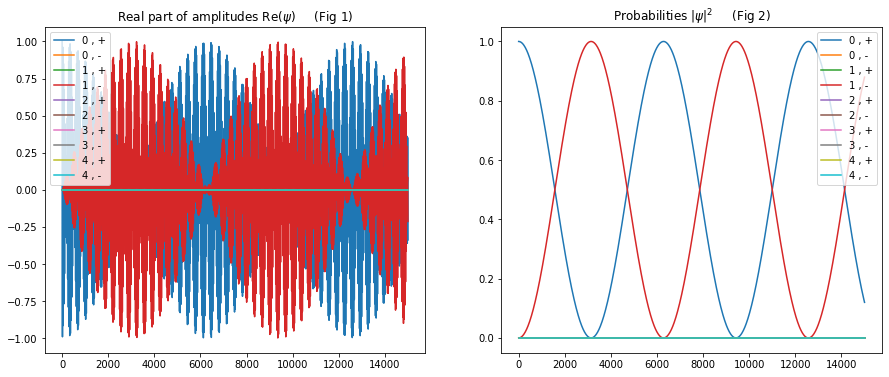

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
df_coupled.plot(title="Real part of amplitudes Re($\psi$)     (Fig 1)", ax=axes[0]);
(df_coupled.abs()**2).plot(title="Probabilities $|\psi|^2$     (Fig 2)", ax=axes[1]);

It's taken us a while but we eventually arrived, as promised. We see in Fig 2 that even though we start with the field "empty" of bosons (blue line), after a while, the field will have a single boson at the expense of the energy in the two state system which transitions to the lower state (red line) - the atom "spontaneously" "emits" a boson. 

Much like the previous two tutorials, we are continuing to see that the evolution of our systems are not irreversible but instead undergo oscillations. The particular oscillation we are seeing in Fig 2 are referred to as [vacuum Rabi oscillations](https://en.wikipedia.org/wiki/Jaynes%E2%80%93Cummings_model#Vacuum_Rabi_Oscillations). This reversibility might seem at odds with what we are taught in introductory quantum classes, particular in the context of spontaneous emission.

Technically, spontaneous emission isn't actually irreversible - if you wait long enough the system will return to its original state. However, the more modes you have (we only have 1), the more places there are for the energy to go. We know from statistical physics what that means - the system will most likely be found in a high entropy state, i.e. not in our special initial condition, but in one where the energy is in the field with its uncountably many modes. 

So, even more exciting stuff can apparently be found by looking at many mode physics. We are not ready to go there just yet though - it's an important topic that needs a longer discussion . For now, you can see how this plays out in detail with 20,000 modes in a paper on [Controlled Spontaneous Emission by Lee](https://iopscience.iop.org/article/10.1088/0953-4075/41/4/045504).

## Next up...


We've covered a **LOT** today so well done for sticking with it. We found some new physics from developing a fully quantum description for the interaction of our two state system with its environment. We'll see next time, through visualising the structure of the Hamiltonian and the resulting energy levels, that there is still lots more to discover using this simplified model of nature. See you then!